In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../../')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)



e:\User\PC\ads_enefit_ueh\ads_enfit


In [2]:
from libs.common import *
from config.config import *
from models.models import VGG16, LSTM, GRU_model

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


e:/User/PC/ads_enefit_ueh/ads_enfit


In [3]:
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/exp2"
os.makedirs(save_dir, exist_ok=True)

In [4]:
plt.style.use(f'{style_dir}/style.mplstyle')
shap.initjs()

In [5]:
# wandb.init(project="enefit_prediction_consumer")


In [6]:
X_train=pd.read_csv(f'{save_dir}/X_train.csv', index_col=None)
X_valid=pd.read_csv(f'{save_dir}/X_valid.csv', index_col=None)
y_train=pd.read_csv(f'{save_dir}/y_train.csv', index_col=None)
y_valid=pd.read_csv(f'{save_dir}/y_valid.csv', index_col=None)
X_test=pd.read_csv(f'{save_dir}/X_test.csv', index_col=None)
y_test=pd.read_csv(f'{save_dir}/y_test.csv', index_col=None)


In [7]:
X_train.drop(columns=['Unnamed: 0'], inplace=True)
# X_valid.drop(columns=['Unnamed: 0'], inplace=True)
y_train.drop(columns=['Unnamed: 0'], inplace=True)
y_valid.drop(columns=['Unnamed: 0'], inplace=True)
X_valid.drop(columns=['Unnamed: 0'], inplace=True)
X_test.drop(columns=['Unnamed: 0'], inplace=True)
y_test.drop(columns=['Unnamed: 0'], inplace=True)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

(1079454, 141) (1079454, 1) (531672, 141) (531672, 1) (6144, 141) (6144, 1)


In [8]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [9]:
gru_model = GRU_model(input_shape=(X_train.shape[1],1)).model
lr=0.0001
gru_model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae', r2])
gru_model.summary()

Model: "model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 141, 1)]          0         
                                                                 
 gru (GRU)                   (None, 128)               50304     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0    

In [10]:
early_stopping = EarlyStopping(monitor='val_loss',
                                mode='min',
    min_delta=0.00005,
    patience=2,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.5,
    patience=6,
    min_lr=0.000001,
    verbose=1,
)
checkpoint_callback = ModelCheckpoint(
    filepath='gru.hdf5', 
    monitor='val_loss', 
    mode='min',
    save_best_only=True, 
    verbose=1,  
    save_format="tf"
)

In [11]:
gru_model.fit(X_train,y_train,
          validation_data=(X_valid,y_valid),
          batch_size=64,epochs= 10000, callbacks=[early_stopping,lr_scheduler,checkpoint_callback])

Epoch 1/10000
16866/16867 [============================>.] - ETA: 0s - loss: 171508.2969 - mae: 119.1969 - r2: 0.6847
Epoch 1: val_loss improved from inf to 121630.94531, saving model to gru.hdf5
16867/16867 [==============================] - 1342s 79ms/step - loss: 171505.8906 - mae: 119.1973 - r2: 0.6847 - val_loss: 121630.9453 - val_mae: 96.4754 - val_r2: 0.8810 - lr: 1.0000e-04
Epoch 2/10000
16866/16867 [============================>.] - ETA: 0s - loss: 130728.9062 - mae: 105.3549 - r2: 0.7431
Epoch 2: val_loss did not improve from 121630.94531
16867/16867 [==============================] - 1338s 79ms/step - loss: 130725.7266 - mae: 105.3534 - r2: 0.7431 - val_loss: 145790.8906 - val_mae: 102.2526 - val_r2: 0.8634 - lr: 1.0000e-04
Epoch 3/10000
16866/16867 [============================>.] - ETA: 0s - loss: 126380.8047 - mae: 103.4227 - r2: 0.7506
Epoch 3: val_loss improved from 121630.94531 to 120586.64844, saving model to gru.hdf5
16867/16867 [==============================] - 132

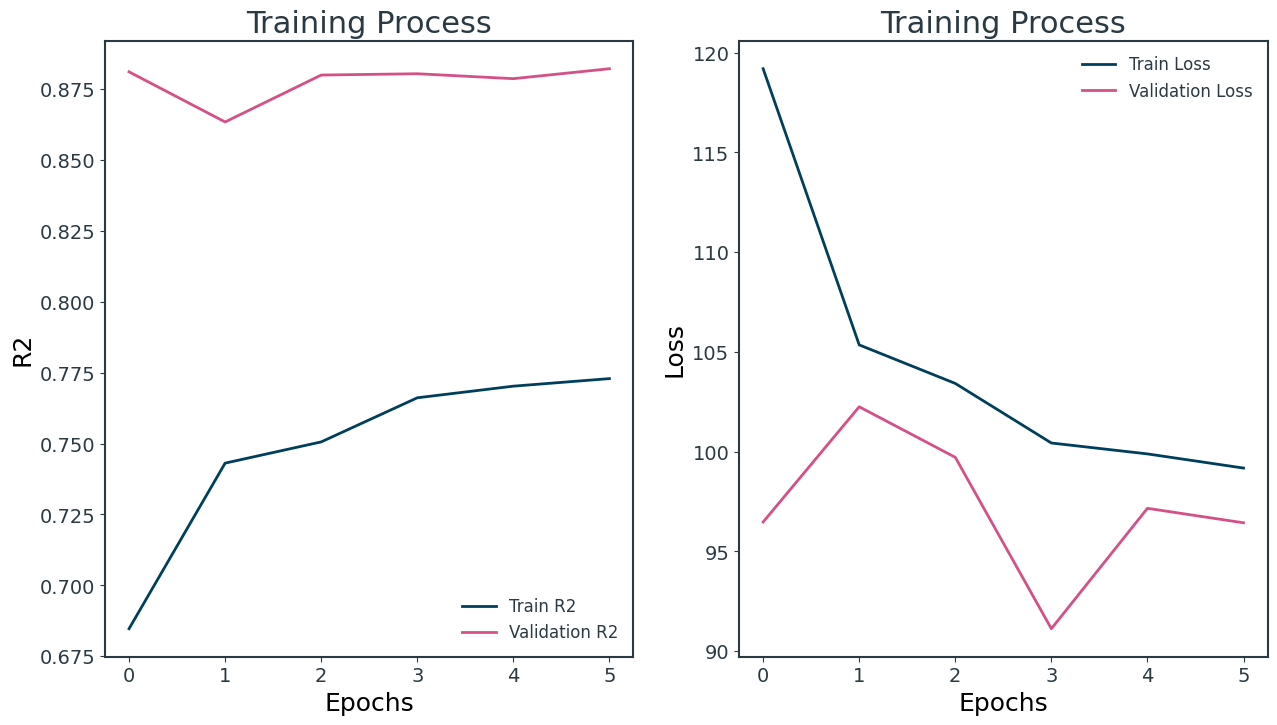

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

history = gru_model.history.history

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

axes[0].plot(pd.DataFrame(history['r2']), label='Train R2')
axes[0].plot(pd.DataFrame(history['val_r2']), label='Validation R2')
axes[0].set_title('Training Process')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('R2')
axes[0].legend()

axes[1].plot(pd.DataFrame(history['mae']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_mae']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()


In [13]:
gru_model.history.history['r2']

[0.6847274303436279,
 0.7430977821350098,
 0.7505837678909302,
 0.7661308646202087,
 0.770229697227478,
 0.7728938460350037]

In [14]:
# Truy cập vào lịch sử của mô hình
training_history = gru_model.history.history

# In ra các keys của lịch sử
print(training_history.keys())

# In ra các giá trị của loss và accuracy qua các epochs
print(training_history['loss'])
print(training_history['val_loss'])

dict_keys(['loss', 'mae', 'r2', 'val_loss', 'val_mae', 'val_r2', 'lr'])
[171505.890625, 130725.7265625, 126377.875, 118616.1796875, 115540.96875, 112922.3984375]
[121630.9453125, 145790.890625, 120586.6484375, 105514.90625, 125786.1875, 115994.0859375]


In [15]:
from sklearn.metrics import r2_score, mean_absolute_error

# Dự đoán trên tập validation
y_pred = gru_model.predict(X_valid)

# Tính toán R2 Score
r2 = r2_score(y_valid, y_pred)

# Tính toán MAE
mae = mean_absolute_error(y_valid, y_pred)

print(f"R2 Score: {r2}")
print(f"MAE: {mae}")


16615/16615 [==============================] - 173s 10ms/step
R2 Score: 0.9055083958202649
MAE: 91.12608704340181
